In [1]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import utils
from itertools import product

plt.style.use('ggplot')
os.chdir('/home/seidi/Repositories/mestrado_final/')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

datasets = {
        'texture_67940': 'Texture_70k',
        'moments_67940': 'Moments_70k',
        'colorHisto_67940': 'Histogram_70k',
        'mnist_69900': 'MNIST_70k',
        'mnist121d_69900': 'MNIST121d_70k',
        'fashion_69900': 'FashionMNIST_70k',
        'sift_999900': 'SIFT_1M',
        'cophir64_999900': 'Cophir64_1M',
        'cophir282_999900': 'Cophir282_1M',
        'base71_999900': 'Synthetic_1M',

        'texture_32000': 'Texture_35k',
        'moments_32000': 'Moments_35k',
        'colorHisto_32000': 'Histogram_35k',
        'mnist_32000': 'MNIST_35k',
        'mnist121d_32000': 'MNIST121d_35k',
        'fashion_32000': 'FashionMNIST_35k',
        'sift_500000': 'SIFT_500k',
        'cophir64_500000': 'Cophir64_500k',
        'cophir282_500000': 'Cophir282_500k',
        'base71_500000': 'Synthetic_500k',

        'texture_16000': 'Texture_16k',
        'moments_16000': 'Moments_16k',
        'colorHisto_16000': 'Histogram_16k',
        'mnist_16000': 'MNIST_16k',
        'mnist121d_16000': 'MNIST121d_16k',
        'fashion_16000': 'FashionMNIST_16k',
        'sift_100000': 'SIFT_100k',
        'cophir64_100000': 'Cophir64_100k',
        'cophir282_100000': 'Cophir282_100k',
        'base71_100000': 'Synthetic_100k',
}

approaches = {
    'gmm': 'GMM',
    'gmm+': 'GMM+',
    'tmm_gs': 'TMM-GS',
    'tmmgs+': 'TMM-GS+',
    'tmm_s': 'TMM-S',
    'tmms+': 'TMM-S+',  
    'Light': 'Loose',
    'Heavy': 'Tight'  
}

graph_type = {
    0: 'NSW',
    1: 'NNDescent',
    2: 'Brute-kNNG',  
}

RECOMMENDATIONS_TYPES = {
    'quick': ['Optimal', 'GMM', 'GMM+', 'Tight', 'Loose'], 
    'tuned': ['Optimal', 'GridSearch', 'TMM-GS', 'TMM-GS+', 'TMM-S', 'TMM-S+']
}
OPTIMIZING_VALUES = {
    'qt': 'Query Time (ms)', 
    'nn': 'NN', 
    'dt': 'Distance Computations'
}

def read_scores(path):
    recs = pd.read_csv(path)
    recs.base = recs.base.map(lambda x: datasets.get(x, x))
    recs.approach = recs.approach.map(lambda x: approaches.get(x, x))
    recs = recs.rename(columns={
        'approach': 'Approach',
        'target': 'Target',
        'base': 'Dataset',
    })
    
    return recs

In [2]:
scores_adbis = pd.read_csv('data/results/info_sys_interpolated/adbis/scores.csv')
scores_adbis.mse = scores_adbis.mse ** (1/2)
scores_adbis = scores_adbis.rename(columns={'approach': 'method', 'mse': 'rmse'})

scores_infsys = pd.read_csv('data/results/info_sys_interpolated/clustering_tuned/scores.csv')
scores_infsys = scores_infsys[scores_infsys.feature_selection_method == 'rf']
scores_infsys.method = scores_infsys.method.apply(lambda x: x + '+')

scores = pd.concat((scores_adbis, scores_infsys))
scores_infsys
scores_adbis
scores.drop(['feature_selection_method', 'eps', 'cluster_size', 'mae'], axis=1, inplace=True)

scores.base = scores.base.map(lambda x: datasets.get(x, x))
scores.method = scores.method.map(lambda x: approaches.get(x, x))
scores = scores.rename(columns={'base': 'Dataset', 'target': 'Meta-target', 'r2': 'R2', 'rmse': 'RMSE', 'method': 'Method'})
scores = scores[scores['Meta-target'] != 'IndexTime']
scores.set_index('Meta-target', inplace=True)
scores = scores.loc[['Recall', 'QueryTime', 'DistComp'], :].reset_index()
scores.Dataset.unique()
scores = scores[~scores.Dataset.isin(['base70','base74','base68','base72'])]
scores

,Meta-target,Dataset,Method,R2,RMSE,elapsed_training,elapsed_inference,k_searching
0,Recall,Texture_70k,GMM,0.723082,0.093548,594.258318,0.526934,30.0
1,Recall,SIFT_1M,GMM,0.803558,0.119650,603.885301,0.536916,30.0
2,Recall,Moments_70k,GMM,0.986759,0.020005,589.639230,0.530893,30.0
3,Recall,MNIST121d_70k,GMM,0.982023,0.031662,600.069351,0.520725,30.0
4,Recall,FashionMNIST_70k,GMM,0.903609,0.077642,589.944382,0.527883,30.0
...,...,...,...,...,...,...,...,...
1633,DistComp,Synthetic_100k,GMM+,0.998695,0.064529,5.681746,0.191653,30.0
1634,DistComp,Synthetic_100k,GMM+,0.997770,0.084355,1.886666,0.179542,10.0
1635,DistComp,Synthetic_100k,TMM-S+,0.974523,0.285279,3.986179,0.185719,1.0
1636,DistComp,Synthetic_100k,TMM-S+,0.999611,0.035251,8.483971,0.184830,30.0


In [3]:
scores.groupby(['Method', 'Meta-target'])['R2'].describe()[['mean', 'std']].round(4) #.to_latex())

mean     std
Method  Meta-target                
GMM     DistComp     0.9338  0.1531
        QueryTime    0.8880  0.1197
        Recall       0.8715  0.1654
GMM+    DistComp     0.9640  0.0525
        QueryTime    0.8488  0.1427
        Recall       0.9397  0.0974
TMM-GS  DistComp     0.9685  0.0641
        QueryTime    0.9217  0.0846
        Recall       0.9348  0.0666
TMM-GS+ DistComp     0.9746  0.0323
        QueryTime    0.9240  0.0589
        Recall       0.9714  0.0317
TMM-S   DistComp     0.9913  0.0336
        QueryTime    0.9579  0.0690
        Recall       0.9664  0.0495
TMM-S+  DistComp     0.9962  0.0112
        QueryTime    0.9821  0.0252
        Recall       0.9813  0.0284

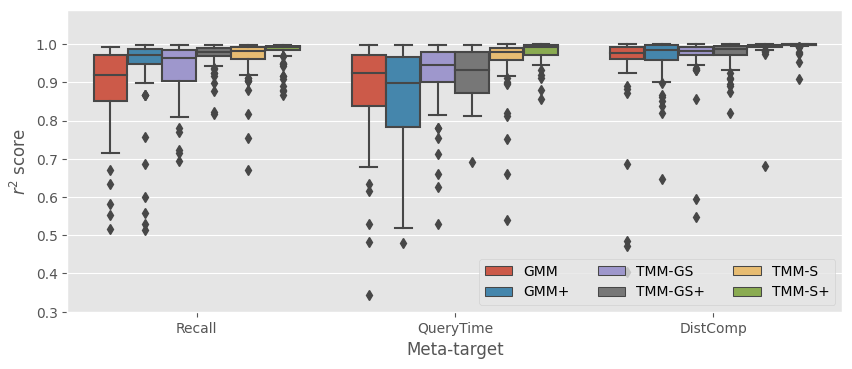

In [4]:
hue_order = ['GMM', 'GMM+', 'TMM-GS', 'TMM-GS+', 'TMM-S', 'TMM-S+']
plt.figure(figsize=(10, 4), dpi=100)
sns.boxplot(x='Meta-target', y='R2', hue='Method', hue_order=hue_order, data=scores)
plt.ylabel(r'$r^2$ score')
plt.ylim(0.3, 1.09)
plt.legend(loc='lower right', ncol=3)
# plt.savefig('/home/seidi/Repositories/Mestrado_quali/figures/journal/results/all_methods.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=300)

In [5]:
scores[~scores.Method.str.endswith('+')].groupby(['Dataset'])['k_searching'].nunique().sort_values()

Dataset
Synthetic_1M        2
Cophir282_100k      3
Texture_16k         3
Synthetic_500k      3
Synthetic_100k      3
SIFT_500k           3
SIFT_1M             3
SIFT_100k           3
Moments_70k         3
Moments_35k         3
Moments_16k         3
MNIST_70k           3
MNIST_35k           3
MNIST_16k           3
MNIST121d_70k       3
MNIST121d_35k       3
MNIST121d_16k       3
Histogram_70k       3
Histogram_35k       3
Histogram_16k       3
FashionMNIST_70k    3
FashionMNIST_35k    3
FashionMNIST_16k    3
Cophir64_500k       3
Cophir64_1M         3
Cophir64_100k       3
Cophir282_500k      3
Cophir282_1M        3
Texture_35k         3
Texture_70k         3
Name: k_searching, dtype: int64